# Median-based Bandits with Unbounded Rewards

We consider the class of upper confidence bound bandit algorithms for sequential experiment design problems.
We propose a policy, $\textit{Median-based Upper Confidence Bound}$ (M-UCB), based on the empirical median, that is robust to skewed distributions and outliers. In each round ${t}$ ($t > K$), pick an arm with index

$$argmax_{i \in \mathcal{K}} \underbrace{\hat{m}_{i, T_i(t-1)}}_{\substack{\text{Empirical} \\ \text{Median}}} + \beta  \underbrace{\left(\sqrt{2v_{i,t} \varepsilon_t} + 2 \varepsilon_t \sqrt{\frac{v_{i,t}}{T_i(t-1)}}\right)}_{\text{Confidence Width}},$$


where $T_i(t-1)$ is the number of times arm $i$ has been played during first $t-1$ rounds, exploration factor $\varepsilon_t = \alpha \log t$ with $\alpha$ controlling the exploration rate, hazard factor $v_{i,t} = \frac{4 }{T_i(t-1) \hat{L}_{i,T_i(t-1)}^2}$, with $\hat{L}_{i, T_i(t-1)}$ as the lower bound estimation of hazard rate for reward distribution of arm $i$ at the round $t$.
    $\beta$ is a hyper-parameter balancing the empirical median and confidence width.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.UCB_discrete import M_UCB, UCB1, UCB_V, MV_LCB, Exp3, epsilon_greedy, Median_of_Means_UCB, U_UCB
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

## Simulations

The performance of our proposed algorithm on simulated dataset is shown in this notebook. We compare our policy (M-UCB) with two mean-based algorithms ([UCB1](https://link.springer.com/article/10.1023/A:1013689704352), [UCB-V](https://linkinghub.elsevier.com/retrieve/pii/S030439750900067X)), one risk-averse algorithm [MV-LCB](http://papers.nips.cc/paper/4753-risk-aversion-in-multi-armed-bandits.pdf) and one adversarial algorithm [Exp3](http://cseweb.ucsd.edu/~yfreund/papers/bandits.pdf) in terms of expected sub-optimal draws and expected regret.
The Exp3 does not make assumptions about the reward distribution, which might suit the outlier setting better.

We simulate 100 independent experiments, for a bandit task with 3 independent arms for 1000 rounds.
We consider two experimental settings, corresponding to two types of reward distributions:
with and no outliers, as summarised in the following table.
The outliers are an absolute Gaussian centred at 20.

<style>
table th:first-of-type {  
    width: 5000px; 
}
</style>

| Arms | No Outliers             | With Outliers                                               |  
|------|-------------------------|-------------------------------------------------------------|
|      |<img width=100/>         |<img width=300/>                                             |
| A    | $|\mathcal{N}(0, 0.5)|$ | $0.95 |\mathcal{N}(0, 0.5)| + 0.05 |\mathcal{N}(20, 0.5)|$  |  
| B    | $|\mathcal{N}(0, 0.1)|$ | $0.95 |\mathcal{N}(0, 0.1)| + 0.05 |\mathcal{N}(20, 0.5)|$  |      
| C    | $Exp(1)$                | $0.95 Exp(1) + 0.05 |\mathcal{N}(20, 0.5)|$                 |

In [3]:
# setting

num_exper = 50
num_rounds = 10000
num_arms = 2

# environment

#{Mixture_AbsGau: [[0, 0.8, 3,5, 0], [4.3, 1, 3,0.8, 1]], Exp: [0.2]}, # mu1, sigma1, mu2, sigma2, p

environments = [
    {Mixture_AbsGau: [[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1]], Exp: [0.28]}, # mu1, sigma1, mu2, sigma2, p
    
]
paras = [50] # [rho for MV]
rewards_env, medians, means, mvs, samples = setup_env(num_arms, environments, paras)

In [4]:
1/3.5

0.2857142857142857

In [5]:
samples

defaultdict(list,
            {'Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]': [array([4.35328618, 3.30755403, 2.11719456, ..., 2.21214588, 1.77867239,
                     3.00732457]),
              array([4.80441782, 2.25655497, 4.51021345, ..., 1.19459029, 2.7877241 ,
                     6.80507502]),
              array([ 3.57959345,  3.13878955, 17.24343943, ...,  0.2010372 ,
                      6.7719475 ,  0.78071051])]})

In [6]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C'
}

for key in medians.keys():
    print(key)
    medians[key] = list(np.around(np.array(medians[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    mvs[key] = list(np.around(np.array(mvs[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row(['Median'] + medians[key]+ [arm_name_dict[np.argmax(medians[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    #t.add_row(['MV']+ mvs[key]+ [arm_name_dict[np.argmin(mvs[key])]])
    print(t)
    print()

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]
+--------+------+------+------+----------+
|  Eva   |  A   |  B   |  C   | Best Arm |
+--------+------+------+------+----------+
| Median | 3.0  | 2.79 | 2.49 |    A     |
|  Mean  | 3.01 | 3.32 | 3.6  |    C     |
+--------+------+------+------+----------+



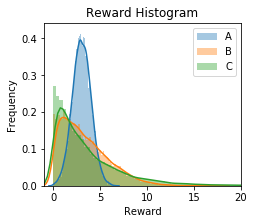

In [7]:
plot_hist(samples)

In [8]:
# run experiments

def run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname]= simulate(rewards_env[key],summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)
                
def run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [True]):
    for key in rewards_env.keys():
        for est_flag in est_flags:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds)
            
            # setting different parameters to with and without outliers groups
            if 'Outlier' in name:
                hyperpara = hyperpara_list[-1]
            else:
                hyperpara = hyperpara_list[0]
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'

            subname = policy_name + str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname]= simulate(rewards_env[key], summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, None, p)

In [9]:
results = defaultdict(dict)


# M-UCB

hyperpara_list = [[4,1,1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians)

#--------------------------------------------------------------------------------------------------------
# Benchmark algorithms

# U-UCB

hyperpara_list = [[4]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, U_UCB, medians)

hyperpara_list = [[0.1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, epsilon_greedy, medians)


hyperpara_list = [[10, 1, 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, Median_of_Means_UCB, means)
'''
# UCB1

hyperpara_list = [[1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, UCB1, means)


# UCB-V

hyperpara_list = [[1.2, 1, 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, UCB_V, means)

# MV-LCB

hyperpara_list = [[paras[0], 1]]
run_exper(rewards_env, hyperpara_list, num_exper, num_rounds, MV_LCB, mvs)
'''

# Exp3

hyperpara_list = [[0.5, 0, 30]]
run_exper_diff_para(rewards_env, hyperpara_list, num_exper, num_rounds, Exp3, means)


Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]_50_10000M_UCB-[4, 1, 1]


IntProgress(value=0, description='Running', max=50)

[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]
[0.008863696823876015, 0.19069390773026207, 0.28]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]_50_10000epsilon_greedy-[0.1]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]_50_10000Median_of_Means_UCB-[10, 1, 1]


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.28]_50_10000Exp3-[0.5, 0, 30]


IntProgress(value=0, description='Running', max=50)

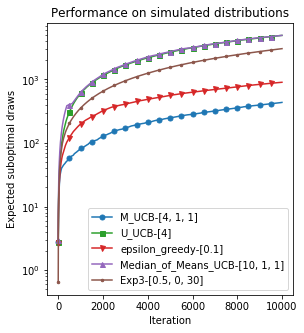

In [10]:
plot_eva(results, 'sd', paper_flag = False)

## Save results

In [11]:
import pickle

with open('simulation4.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot results

In [12]:
import pickle
from codes.plots import plot_hist, plot_eva

with open('simulation4.pickle', 'rb') as handle:
    results = pickle.load(handle)

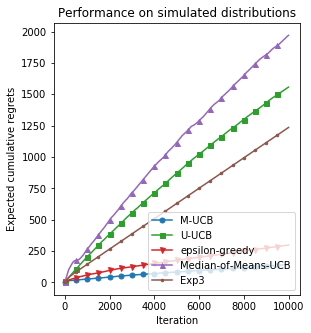

In [13]:
plot_eva(results, 'r')

M-UCB outperforms other methods and has a stable performance for the situations with or without outliers, in terms of both expected sub-optimal draws and expected regret.
Unsurprisingly, mean-based algorithms (UCB1 and UCB-V) are more sensitive to outliers compared to the risk-averse MV-LCB and our algorithm, especially when the support of outliers is bigger than assumed reward support.
Surprisingly, the outliers also cause the adversarial algorithm Exp3 to have worse performance. From the plot of the expected sub-optimal draws, we observe that MV-LCB is robust to outliers but still has a larger number of sub-optimal draws than M-UCB.